## Experiment-5:

<br/><br/>
<font size="5", color="MediumBlue">
<b>Conditional Adversarial Autoencoder</b>
</font>

<hr>
<font color="MidNightBlue">
You can post your queries on the google group: https://groups.google.com/forum/#!categories/summer-school-on-machine-learning-2017/lab-4
</font>
<hr>

<hr>
<font size="2", color="RoyalBlue">
In the previous notebook, we trained an <b>Adversarial Autoencoder (AAE)</b> on unsupervised data. We can also train an AAE with additional label information as input. This allows us to train a conditional generator that can generate samples corresponding to specific input conditionals.
</font>
<hr>

<hr>
<font size="2", color="RoyalBlue">
The architecture of a Conditional Adversarial Autoencoder looks as follows,
<img src="images/saae_1.png", width="600", align=”left”>
</font>
<hr>

<hr>
<font size="4", color="RoyalBlue">
Let's now learn an Adversarial Autoencoder that can generate specific digits similar to the ones in the MNIST dataset in a controlled manner. 
</font>
<hr>

In [1]:
##########################
# Import necessary modules
##########################

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
################
# Set parameters
################

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 10

n_classes = 10
z_dim = 2
X_dim = 784
y_dim = 10
train_batch_size = 100
valid_batch_size = train_batch_size
N = 1000
epochs = 5

params = {}
params['cuda'] = cuda
params['n_classes'] = n_classes
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['y_dim'] = y_dim
params['train_batch_size'] = train_batch_size
params['valid_batch_size'] = valid_batch_size
params['N'] = N
params['epochs'] = epochs


In [3]:
###################################
# Load data and create Data loaders
###################################

def load_data(data_path='../../data/lab4/'):
    print('loading data!')
    trainset_labeled = pickle.load(open(data_path + "train_labeled.p", "rb"))
    trainset_unlabeled = pickle.load(open(data_path + "train_unlabeled.p", "rb"))
    # Set -1 as labels for unlabeled data
    trainset_unlabeled.train_labels = torch.from_numpy(np.array([-1] * 47000))
    validset = pickle.load(open(data_path + "validation.p", "rb"))

    train_labeled_loader = torch.utils.data.DataLoader(trainset_labeled,
                                                       batch_size=train_batch_size,
                                                       shuffle=True, **kwargs)

    train_unlabeled_loader = torch.utils.data.DataLoader(trainset_unlabeled,
                                                         batch_size=train_batch_size,
                                                         shuffle=True, **kwargs)

    valid_loader = torch.utils.data.DataLoader(validset, batch_size=valid_batch_size, shuffle=True)

    return train_labeled_loader, train_unlabeled_loader, valid_loader



In [4]:
#################
# Define Networks
#################

# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss = nn.Linear(N, z_dim)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)

        return xgauss


# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim + n_classes, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)


class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)

        return F.sigmoid(self.lin3(x))  


In [5]:
###################
# Utility functions
###################

def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, D_loss_gauss, G_loss, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; D_loss_gauss: {:.4}; G_loss: {:.4}; recon_loss: {:.4}'.format(epoch,
                                                                                   D_loss_gauss.data[0],
                                                                                   G_loss.data[0],
                                                                                   recon_loss.data[0]))


def create_latent(Q, loader):
    '''
    Creates the latent representation for the samples in loader
    return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    Q.eval()
    labels = []

    for batch_idx, (X, target) in enumerate(loader):

        X = X * 0.3081 + 0.1307
        # X.resize_(loader.batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        labels.extend(target.data.tolist())
        if cuda:
            X, target = X.cuda(), target.cuda()
        # Reconstruction phase
        z_sample = Q(X)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z_sample.data.tolist())))
        else:
            z_values = np.array(z_sample.data.tolist())
    labels = np.array(labels)

    return z_values, labels


def get_categorical(labels, n_classes=10):
    cat = np.array(labels.data.tolist())
    cat = np.eye(n_classes)[cat].astype('float32')
    cat = torch.from_numpy(cat)
    return Variable(cat)  


def get_X_batch(data_loader, params, size=None):
    if size is None:
        size = data_loader.batch_size
        
    data_loader.batch_size = size
    
    for X, target in data_loader:
        break

    train_batch_size = params['train_batch_size']
    X_dim = params['X_dim']
    cuda = params['cuda']

    X = X * 0.3081 + 0.1307

    X = X[:size]
    target = target[:size]

    X.resize_(size, X_dim)
    X, target = Variable(X), Variable(target)

    if cuda:
        X, target = X.cuda(), target.cuda()

    return X, target


In [6]:
####################
# Training procedure
####################

def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for X, target in data_loader:

        # Load batch and normalize samples to be between 0 and 1
        X = X * 0.3081 + 0.1307
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        
        # Reconstruction phase

        z_gauss = Q(X)
        z_cat = get_categorical(target, n_classes=10)
        if cuda:
            z_cat = z_cat.cuda()

        z_sample = torch.cat((z_cat, z_gauss), 1)

        X_sample = P(z_sample)
        recon_loss = F.binary_cross_entropy(X_sample + TINY, X.resize(train_batch_size, X_dim) + TINY)

        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()


        # Regularization phase

        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, z_dim) * 5.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)

        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))

        D_loss.backward()
        D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))

        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

    return D_loss, G_loss, recon_loss


def generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.0001
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

    for epoch in range(epochs):
        D_loss_gauss, G_loss, recon_loss = train(P, Q, D_gauss, P_decoder, Q_encoder,
                                                 Q_generator,
                                                 D_gauss_solver,
                                                 valid_loader)
        if epoch % 1 == 0:
            report_loss(epoch, D_loss_gauss, G_loss, recon_loss)

    return Q, P


In [7]:
##########################
# Train a generative model
##########################

train_labeled_loader, train_unlabeled_loader, valid_loader = load_data()
Q, P = generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader)

loading data!
3000
750
Epoch-0; D_loss_gauss: 0.5426; G_loss: 1.665; recon_loss: 0.2617
Epoch-1; D_loss_gauss: 0.7707; G_loss: 1.683; recon_loss: 0.2481
Epoch-2; D_loss_gauss: 0.8349; G_loss: 1.586; recon_loss: 0.2316
Epoch-3; D_loss_gauss: 0.9327; G_loss: 1.265; recon_loss: 0.2226
Epoch-4; D_loss_gauss: 0.9839; G_loss: 1.172; recon_loss: 0.2001


In [9]:
####################
# Save trained model
####################

# Save trained model
# torch.save(Q,'TrainedModels/SAAE_mytraining_Q.pt')
# torch.save(P,'TrainedModels/SAAE_mytraining_P.pt')

In [10]:
####################
# Load trained model
####################

# Load model trained for 500 epochs
Q_pt = torch.load('../../data/lab4/TrainedModels/SAAE_preTrained_Q.pt')
P_pt = torch.load('../../data/lab4/TrainedModels/SAAE_preTrained_P.pt')

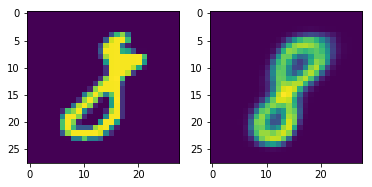

In [11]:
##########################
# Visualize reconstruction
##########################

def create_reconstruction(Q, P, data_loader, params):
    Q.eval()
    P.eval()
    X, label = get_X_batch(data_loader, params, size=1)

    z_g = Q(X)
    z_c = get_categorical(label, n_classes=10)
    if cuda:
        z_c = z_c.cuda()
    z = torch.cat((z_c, z_g), 1)
    x = P(z)

    img_orig = np.array(X[0].data.tolist()).reshape(28, 28)
    img_rec = np.array(x[0].data.tolist()).reshape(28, 28)
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.subplot(1, 2, 2)
    plt.imshow(img_rec)
    

data_loader = valid_loader    # Training data:  train_unlabeled_loader  |  Validation data:  valid_loader

create_reconstruction(Q_pt, P_pt, data_loader, params)   
plt.show()

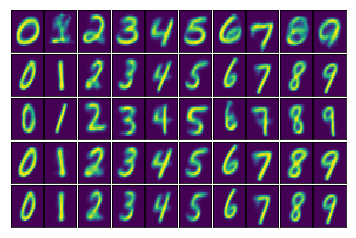

In [12]:
######################
# Visualize generation
######################

def grid_plot(Q, P, data_loader, params):
    Q.eval()
    P.eval()
    X,_ = get_X_batch(data_loader, params, size=10)
    z_g = Q(X)

    n_classes = params['n_classes']
    cuda = params['cuda']
    z_dim = params['z_dim']

    z_cat = np.arange(0, n_classes)
    z_cat = np.eye(n_classes)[z_cat].astype('float32')
    z_cat = torch.from_numpy(z_cat)
    z_cat = Variable(z_cat)
    if cuda:
        z_cat = z_cat.cuda()

    nx, ny = 5, n_classes
    plt.subplot()
    gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

    for i, g in enumerate(gs):
        z_gauss = z_g[i / ny].resize(1, z_dim)
        z_gauss0 = z_g[i / ny].resize(1, z_dim)

        for _ in range(n_classes - 1):
            z_gauss = torch.cat((z_gauss, z_gauss0), 0)

        z = torch.cat((z_cat, z_gauss), 1)
        x = P(z)

        ax = plt.subplot(g)
        img = np.array(x[i % ny].data.tolist()).reshape(28, 28)
        ax.imshow(img, )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')


grid_plot(Q_pt, P_pt, data_loader, params)
plt.show()

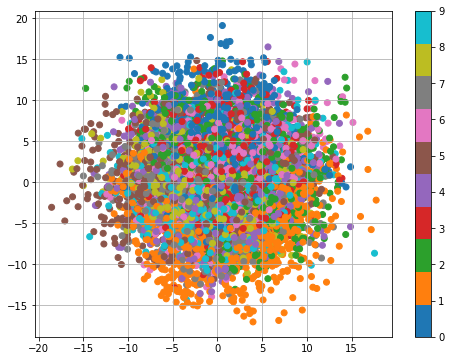

In [13]:
###############################
# Visualize latent distribution
###############################

Q_pt.eval()
P_pt.eval()

X, label = get_X_batch(data_loader, params, size=10000)
z = Q_pt(X)

z = np.array(z.data.tolist())
label = np.array(label.data.tolist())
                
plt.figure(figsize=(8, 6)) 
plt.scatter(z[:,0], z[:,1], c=label, cmap='tab10')
plt.colorbar()
plt.grid()
plt.show()

<hr>
<font size="2", color="RoyalBlue">
Now, compare the latent distribution as learned by the standard Adversarial Autoencoder to that of the Conditional Adversarial Autoencoder. It looks significantly different, why do you think this happened?
</font>
<hr>

Since the input to which digit is to be generated is already given, the latent space is ignoring the distinction.

<hr>
<font size="4", color="RoyalBlue">
Now, remember the 'CVIT' distribution from the first notebook? Here it is again,
<img src="images/cvit_dist.png", width="300", align=”left”>
Can you learn a Conditional Adversarial Autoencoder that models this distribution.
</font>
<hr>

In [14]:
#####################################
# Reset workspace for next experiment
#####################################

%reset -f

In [15]:
##########################
# Import necessary modules
##########################

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [16]:
################
# Set parameters
################

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 10

n_classes = 5
z_dim = 2
X_dim = 2
y_dim = 5
train_batch_size = 100
valid_batch_size = train_batch_size
N = 1000
epochs = 100

params = {}
params['cuda'] = cuda
params['n_classes'] = n_classes
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['y_dim'] = y_dim
params['train_batch_size'] = train_batch_size
params['valid_batch_size'] = valid_batch_size
params['N'] = N
params['epochs'] = epochs


In [17]:
####################
# Define Data-loader
####################

#########################################
# Deterministic transformation for 'CVIT'
#########################################

def transformation_cvit(z12,z3):

    os = 10
    ost = np.pi/2
    
    x = np.zeros((len(z3),2)).astype(np.float32)

    for i in range(len(z3)):

        z1 = z12[i,0]
        z2 = z12[i,1]

        idx = z3[i]

        if idx==0:
            # C
            x2 = (os+z1)*np.cos(z2+ost)
            x1 = -(1.5*os+z1)*np.abs(np.sin(z2+ost))
        elif idx==1:
            # V
            x1 = 20+(os+z1)*np.cos(z2+ost)
            x2 = 12-0.6*(4*os+z1)*np.abs(np.sin(z2+ost))
        elif idx==2:
            # I
            x2 = (10+z1)*np.cos(z2+ost)
            x1 = 40+(1+z1)*(np.sin(z2+ost))
        elif idx==3:
            # T_h
            x1 = 60+(10+z1)*np.cos(z2+ost)
            x2 = 10+(1+z1)*(np.sin(z2+ost))
        elif idx==4:
            # T_v
            x2 = (10+z1)*np.cos(z2+ost)
            x1 = 60+(1+z1)*(np.sin(z2+ost))

        x[i,0] = x1
        x[i,1] = x2
        
    return x


def data_loader_CVITdist(numSamples):

    z12 = np.random.randn(numSamples,2).astype(np.float32)                # Sample [z1,z2] from Gaussian distribution
    z3 = np.random.randint(0,high=5,size=(numSamples,1))      # Sample [z3] from Multinomial distribution

    x = transformation_cvit(z12,z3)                             # Apply deterministic transformation
    target = z3
    
    return torch.from_numpy(x), torch.from_numpy(target)

In [18]:
#################
# Define Networks
#################

# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss = nn.Linear(N, z_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)

        return xgauss


# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim + n_classes, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x


class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)

        return F.sigmoid(self.lin3(x))  


In [19]:
###################
# Utility functions
###################


def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; recon_loss: {:.4}'.format(epoch,recon_loss.data[0]))
    

def get_categorical(labels, n_classes=5):
    cat = np.array(labels.data.tolist())
    cat = np.eye(n_classes)[cat].astype('float32')
    cat = torch.from_numpy(cat.squeeze())
    return Variable(cat)  


In [20]:
####################
# Training procedure
####################

def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for it in range(100):
        
        X, target = data_loader(train_batch_size)

        X.resize_(train_batch_size, X_dim)        
        
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        
        # Reconstruction phase

        z_gauss = Q(X)
        z_cat = get_categorical(target, n_classes=5)
        if cuda:
            z_cat = z_cat.cuda()

        z_sample = torch.cat((z_cat, z_gauss), 1)

        X_sample = P(z_sample)
        
        criterion = nn.MSELoss()
        #criterion.size_average = False
        recon_loss = criterion(X_sample, X.resize(train_batch_size, X_dim))
        
        #recon_loss = F.binary_cross_entropy(X_sample + TINY, X.resize(train_batch_size, X_dim) + TINY)

        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()


        # Regularization phase

        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, z_dim) * 1.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)

        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))

        D_loss.backward()
        D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))

        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

    return D_loss, G_loss, recon_loss


def generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.00005
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

    for epoch in range(epochs):
        D_loss_gauss, G_loss, recon_loss = train(P, Q, D_gauss, P_decoder, Q_encoder,
                                                 Q_generator,
                                                 D_gauss_solver,
                                                 data_loader_CVITdist)
        if epoch % 10 == 0:
            report_loss(epoch, recon_loss)

    return Q, P


In [21]:
##########################
# Train a generative model
##########################

Q, P = generate_model(data_loader_CVITdist, data_loader_CVITdist, data_loader_CVITdist)

Epoch-0; recon_loss: 60.78
Epoch-10; recon_loss: 6.448
Epoch-20; recon_loss: 7.914
Epoch-30; recon_loss: 8.898
Epoch-40; recon_loss: 23.01
Epoch-50; recon_loss: 15.46
Epoch-60; recon_loss: 13.62
Epoch-70; recon_loss: 10.5
Epoch-80; recon_loss: 13.29
Epoch-90; recon_loss: 10.66


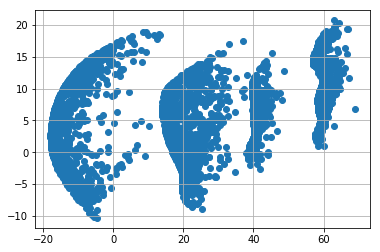

In [22]:
##################################
# Visualize generated distribution
##################################

def generate_CVITdist(numSamples):
    
    z12 = np.random.randn(numSamples,2).astype(np.float32)                # Sample [z1,z2] from Gaussian distribution
    z3 = np.random.randint(0,high=5,size=(numSamples,1))      # Sample [z3] from Multinomial distribution

    z12 = Variable(torch.from_numpy(z12))
    z3 = Variable(torch.from_numpy(z3))    
        
    z_gauss = z12
    z_cat = get_categorical(z3, n_classes=5)
    if cuda:
        z_gauss = z_gauss.cuda()
        z_cat = z_cat.cuda()

    z_sample = torch.cat((z_cat, z_gauss), 1)

    x = P(z_sample)    
    x = np.array(x.data.tolist())
    
    return x


numGenSamples = 5000

x = generate_CVITdist(numGenSamples)

x1 = x[:,0]
x2 = x[:,1]

plt.scatter(x1,x2)
plt.hold()
plt.grid(True)
plt.show()


<hr>
<font size="2", color="RoyalBlue">
The Conditional Adversarial Autoencoder seems to have done a half-decent job at modelling the 'CVIT' distribution. Can you try and tune the AAE so that it models the distribution even better.
</font>
<hr>